# Import Packages and Load Data

In [1]:
!pip install category_encoders

     |████████████████████████████████| 81kB 5.5MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataframe = pd.read_csv('drive/MyDrive/spotify_billboard.csv', index_col=False)

In [5]:
dataframe.shape

(40363, 23)

#Preprocessing

## Data Wrangling

In [6]:
df = dataframe

In [7]:
df_test = df[df['billboard_appearance'] == 1]

In [8]:
df = df.set_index('id')

In [9]:
# drop columns not needed for model
df = df.drop(['Unnamed: 0', 'release_date', 'name', 'song_id', 'artists', 'year'], axis=1)

In [10]:
df.head(1)

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,primary_artist,billboard_appearance
id,,,,,,,,,,,,,,,,
03TzvVWdkVbLT9pzewYiDw,0.0785,0.587,200733,0.635,1,0.0,8,0.175,-6.369,1,64,0.422,82.517,0.758,lil wayne,0


In [11]:
explicit_onehot = pd.get_dummies(df.explicit, prefix='explicit')
key_onehot = pd.get_dummies(df.key, prefix='key')
mode_onehot = pd.get_dummies(df['mode'], prefix='mode')
df = pd.concat([df,explicit_onehot, key_onehot, mode_onehot],axis=1)
df = df.drop(columns=['key','mode','explicit'])

In [12]:
df.head(1)

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,primary_artist,billboard_appearance,explicit_0,explicit_1,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
03TzvVWdkVbLT9pzewYiDw,0.0785,0.587,200733,0.635,0.0,0.175,-6.369,64,0.422,82.517,0.758,lil wayne,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [13]:
# Target encode the artist 

encoder = TargetEncoder()
df['Artist_Encoded'] = encoder.fit_transform(df['primary_artist'],df['popularity'])

df = df.drop(columns='primary_artist')

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [14]:
df.head(1)

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,billboard_appearance,explicit_0,explicit_1,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1,Artist_Encoded
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
03TzvVWdkVbLT9pzewYiDw,0.0785,0.587,200733,0.635,0.0,0.175,-6.369,64,0.422,82.517,0.758,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,51.097087


In [15]:
df.shape

(40363, 29)

In [16]:
numericalFeatures = ['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness', 'popularity', 'speechiness','tempo','valence']

In [17]:
min_max_scaler = MinMaxScaler()
df[numericalFeatures] = min_max_scaler.fit_transform(df[numericalFeatures])

In [18]:
df_test = df[df['billboard_appearance'] == 1]
df_test.shape

(4182, 29)

## Initialize train, validation, and test data

In [19]:
X = df.drop('billboard_appearance', axis=1)

In [20]:
y = df['billboard_appearance']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [22]:
#Perfrom undersampling for improved training
re_sampler = RandomUnderSampler()
X_train, y_train = re_sampler.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#Dimensionality Reduction

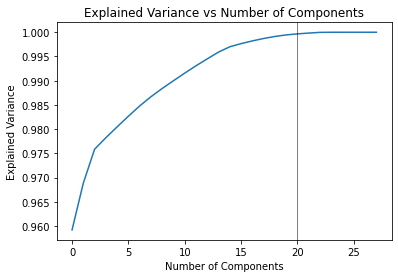

In [23]:
pca = PCA()
pca_X_train = pca.fit_transform(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained Variance vs Number of Components')
plt.ylabel('Explained Variance')
plt.xlabel('Number of Components')
plt.axvline(x=20, lw=0.5, c='black')

In [24]:
pca = PCA(n_components=22)

X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)

#Model Building

##Helper Functions

In [25]:
# return all metrics for determining quality of model
def get_classification_metrics(actual, pred):
  print(confusion_matrix(actual, pred))
  print('Accuracy: {}, Precision: {}, Recall: {}, F1 Score: {}'.format(
      accuracy_score(actual, pred),
      precision_score(actual, pred),
      recall_score(actual, pred),
      f1_score(actual, pred)))

In [26]:
def hyp_tuning(model_list, param_grid_list, X_train, y_train, X_test, y_test):
    
    for i in range(len(model_list)):
        print(model_list[i])
        grid_search = GridSearchCV(model_list[i], param_grid_list[i], cv = 5, scoring = 'accuracy')
        grid_search.fit(X_train, y_train)
        print('Best Parameters: {}'.format(grid_search.best_params_))
        best_cross_val_score = grid_search.best_score_
        print('Best Cross Validation Score: {}'.format(best_cross_val_score))
        # Score on the test set
        test_score = grid_search.score(X_test, y_test)
        print('Validation Set Score: {}'.format(test_score))

##Logistic Regression

Hyperparameter Tuning

In [27]:
param_grid_logistic = {'C': [3,4,5,6]}

model_list = [LogisticRegression(max_iter = 1000)]
param_grid_list = [param_grid_logistic]

hyp_tuning(model_list, param_grid_list, X_train, y_train, X_test, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best Parameters: {'C': 5}
Best Cross Validation Score: 0.6306292099118593
Validation Set Score: 0.5180230397621702


Fitting and Predicting

In [28]:
clf = LogisticRegression(C=5, random_state=0, max_iter=1000)
clf.fit(X_train, y_train)
y_train_pred_log = clf.predict(X_train)
y_test_pred_log = clf.predict(X_test)

In [29]:
# Save the predictions
log_predictions_train = y_train_pred_log
log_predictions_test = y_test_pred_log

Classification Metrics

In [30]:
# Classification metrics for training data
print('Training')
get_classification_metrics(y_train, y_train_pred_log)

print("")

# Classification metrics for test data
print('Test')
get_classification_metrics(y_test, y_test_pred_log)

Training
[[1779 1574]
 [ 876 2477]]
Accuracy: 0.6346555323590815, Precision: 0.6114539619846951, Recall: 0.7387414255890248, F1 Score: 0.6690977849810913

Test
[[3629 3615]
 [ 276  553]]
Accuracy: 0.5180230397621702, Precision: 0.1326775431861804, Recall: 0.6670687575392038, F1 Score: 0.22133279967980787


##Random Forest

Hyperparameter Tuning

In [33]:
# define hyperparameter grid
param_grid_rf = [
    {'max_depth': [9, 10, 11], 'n_estimators': [100, 110, 120]}
]

model_list = [RandomForestClassifier()]
param_grid_list = [param_grid_rf]

hyp_tuning(model_list, param_grid_list, X_train, y_train, X_test, y_test)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Best Parameters: {'max_depth': 11, 'n_estimators': 120}
Best Cross Validation Score: 0.6576206558932932
Validation Set Score: 0.7013501796110492


Fitting and Predicting

In [34]:
clf = RandomForestClassifier(max_depth=11, n_estimators=120)
clf.fit(X_train, y_train)
y_train_pred_rf = clf.predict(X_train)
y_test_pred_rf = clf.predict(X_test)

In [35]:
# Save the predictions
rf_predictions_train = y_train_pred_rf
rf_predictions_test = y_test_pred_rf

Classification Metrics

In [36]:
# Classification metrics for training data
print('Training')
get_classification_metrics(y_train, y_train_pred_rf)

print("")

# Classification metrics for test data
print('Test')
get_classification_metrics(y_test, y_test_pred_rf)

Training
[[2627  726]
 [  44 3309]]
Accuracy: 0.8851774530271399, Precision: 0.8200743494423792, Recall: 0.9868774232031017, F1 Score: 0.8957769355711965

Test
[[5235 2009]
 [ 469  360]]
Accuracy: 0.6930509104422148, Precision: 0.15196285352469396, Recall: 0.43425814234016885, F1 Score: 0.225140712945591


##Adaboost

Hyperparameter Tuning

In [38]:
param_grid_ada={'learning_rate':[0.3, 0.4, 0.5], 'n_estimators':[150, 170, 190]}

model_list = [AdaBoostClassifier()]
param_grid_list = [param_grid_ada]

hyp_tuning(model_list, param_grid_list, X_train, y_train, X_test, y_test)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Best Parameters: {'learning_rate': 0.4, 'n_estimators': 170}
Best Cross Validation Score: 0.654488664841839
Validation Set Score: 0.6955283042239564


Fitting and Predicting

In [42]:
clf = AdaBoostClassifier(n_estimators=170, learning_rate=0.4, random_state=20)
clf.fit(X_train, y_train)
y_train_pred_ada = clf.predict(X_train)
y_test_pred_ada = clf.predict(X_test)

In [43]:
# Save the predictions
ada_predictions_train = y_train_pred_ada
ada_predictions_test = y_test_pred_ada

Classification Metrics

In [44]:
# Classification metrics for training data
print('Training')
get_classification_metrics(y_train, y_train_pred_ada)

print("")

# Classification metrics for test data
print('Test')
get_classification_metrics(y_test, y_test_pred_ada)

Training
[[2033 1320]
 [ 727 2626]]
Accuracy: 0.6947509692812407, Precision: 0.6654840344652813, Recall: 0.7831792424694304, F1 Score: 0.7195506233730649

Test
[[5246 1998]
 [ 460  369]]
Accuracy: 0.6955283042239564, Precision: 0.155893536121673, Recall: 0.4451145958986731, F1 Score: 0.2309136420525657


##SVM

Hyperparameter Tuning

In [45]:
list_kernel_type = ['linear', 'poly', 'rbf']
random_state = 20

objs_KSVM = [SVC(kernel=kernel_type, random_state=random_state) for kernel_type in list_kernel_type]

for model in objs_KSVM:
  model.fit(X_train, y_train)
  print(model.score(X_test, y_test))

0.46636937941285767
0.2598786077046947
0.43057103926669144


Fitting and Predicting

In [47]:
clf = SVC(kernel='linear', random_state=20)
clf.fit(X_train, y_train)
y_train_pred_svm = clf.predict(X_train)
y_test_pred_svm = clf.predict(X_test)

In [48]:
# Save the predictions
svm_predictions_train = y_train_pred_svm
svm_predictions_test = y_test_pred_svm

Classification Metrics

In [49]:
# Classification metrics for training data
print('Training')
get_classification_metrics(y_train, y_train_pred_svm)

print("")

# Classification metrics for test data
print('Test')
get_classification_metrics(y_test, y_test_pred_svm)

Training
[[1496 1857]
 [ 656 2697]]
Accuracy: 0.6252609603340292, Precision: 0.5922266139657444, Recall: 0.8043543095735163, F1 Score: 0.6821803465283924

Test
[[3170 4074]
 [ 234  595]]
Accuracy: 0.46636937941285767, Precision: 0.12743628185907047, Recall: 0.7177322074788902, F1 Score: 0.21644234267006182


##kNN

Hyperparameter Tuning

In [51]:
param_grid_knn={'n_neighbors':[8, 9, 10]}

model_list = [KNeighborsClassifier()]
param_grid_list = [param_grid_knn]

hyp_tuning(model_list, param_grid_list, X_train, y_train, X_test, y_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Best Parameters: {'n_neighbors': 9}
Best Cross Validation Score: 0.5808231950931919
Validation Set Score: 0.43874643874643876


Fitting and Predicting

In [52]:
clf = KNeighborsClassifier(n_neighbors=9)
clf.fit(X_train, y_train)
y_train_pred_knn = clf.predict(X_train)
y_test_pred_knn = clf.predict(X_test)

In [53]:
# Save the predictions
knn_predictions_train = y_train_pred_knn
knn_predictions_test = y_test_pred_knn

Classification Metrics

In [54]:
# Classification metrics for training data
print('Training')
get_classification_metrics(y_train, y_train_pred_knn)

print("")

# Classification metrics for test data
print('Test')
get_classification_metrics(y_test, y_test_pred_knn)

Training
[[1969 1384]
 [ 750 2603]]
Accuracy: 0.6817775126752162, Precision: 0.6528718334587409, Recall: 0.7763197136892335, F1 Score: 0.7092643051771117

Test
[[2978 4266]
 [ 265  564]]
Accuracy: 0.43874643874643876, Precision: 0.11677018633540373, Recall: 0.6803377563329313, F1 Score: 0.19932850326912885


#Ensemble

##Dataframe Assembly

In [55]:
# initialize dataframe of supervised results with log predictions
supervised_train_df = pd.DataFrame(log_predictions_train, columns = ['log_predictions_train'])
supervised_train_df['rf_predictions_train'] = rf_predictions_train
supervised_train_df['ada_predictions_train'] = ada_predictions_train
supervised_train_df['svm_predictions_train'] = svm_predictions_train
supervised_train_df['knn_predictions_train'] = knn_predictions_train

In [56]:
# initialize dataframe of supervised results with log predictions
supervised_test_df = pd.DataFrame(log_predictions_test, columns = ['log_predictions_test'])
supervised_test_df['rf_predictions_test'] = rf_predictions_test
supervised_test_df['ada_predictions_test'] = ada_predictions_test
supervised_test_df['svm_predictions_test'] = svm_predictions_test
supervised_test_df['knn_predictions_test'] = knn_predictions_test

In [57]:
supervised_train_df.head()

,log_predictions_train,rf_predictions_train,ada_predictions_train,svm_predictions_train,knn_predictions_train
0,1,1,1,1,1
1,1,0,0,1,0
2,0,0,0,0,0
3,1,0,1,1,0
4,1,0,1,1,0


In [58]:
supervised_test_df.head()

,log_predictions_test,rf_predictions_test,ada_predictions_test,svm_predictions_test,knn_predictions_test
0,0,0,0,1,1
1,1,0,0,1,1
2,1,0,0,1,1
3,1,1,1,1,1
4,1,1,1,1,1


##Random Forest on Individual Learners

In [63]:
# define hyperparameter grid
param_grid_rf = [
    {'max_depth': [2, 3], 'min_samples_split': [2,3]}
]

model_list = [RandomForestClassifier()]
param_grid_list = [param_grid_rf]

hyp_tuning(model_list, param_grid_list, supervised_train_df, y_train, supervised_test_df, y_test)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Best Parameters: {'max_depth': 2, 'min_samples_split': 2}
Best Cross Validation Score: 0.88517699828075
Validation Set Score: 0.6930509104422148


In [64]:
clf = RandomForestClassifier(max_depth=2, min_samples_split=2)
clf.fit(supervised_train_df, y_train)
y_train_pred_ensemble = clf.predict(supervised_train_df)
y_test_pred_ensemble = clf.predict(supervised_test_df)

In [65]:
# Classification metrics for training data
print('Training')
get_classification_metrics(y_train, y_train_pred_ensemble)

print("")

# Classification metrics for test data
print('Test')
get_classification_metrics(y_test, y_test_pred_ensemble)

Training
[[2627  726]
 [  44 3309]]
Accuracy: 0.8851774530271399, Precision: 0.8200743494423792, Recall: 0.9868774232031017, F1 Score: 0.8957769355711965

Test
[[5235 2009]
 [ 469  360]]
Accuracy: 0.6930509104422148, Precision: 0.15196285352469396, Recall: 0.43425814234016885, F1 Score: 0.225140712945591
